In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

import os
from IPython.display import clear_output

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold


def get_results(clf, X, y):
    accs = []
    sens = []
    spes = []

    kf = StratifiedKFold(n_splits=10, shuffle=True)

    fold = 0
    for train_idx, test_idx in kf.split(X, y):
        fold += 1

        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        confusion = confusion_matrix(y_test, y_pred)
        (
            true_negatives,
            false_positives,
            false_negatives,
            true_positives,
        ) = confusion.ravel()

        acc = accuracy_score(y_test, y_pred)
        print(false_negatives, false_positives)
        sen = true_positives / (true_positives + false_negatives)
        spe = true_negatives / (true_negatives + false_positives)

        print(
            f"Fold {fold}: Accuracy: {acc:.3f}, Sensitivity: {sen:.3f}, Specificity: {spe:.3f}"
        )

        accs.append(acc)
        spes.append(spe)
        sens.append(sen)

    mean_acc = np.mean(accs)
    mean_sen = np.mean(sens)
    mean_spe = np.mean(spes)

    std_accuracy = np.std(accs)
    std_sensitivity = np.std(sens)
    std_specificity = np.std(spes)

    print(f"Mean Accuracy: {mean_acc:.3f} ± {std_accuracy:.3f}")
    print(f"Mean Sensitivity: {mean_sen:.3f} ± {std_sensitivity:.3f}")
    print(f"Mean Specificity: {mean_spe:.3f} ± {std_specificity:.3f}")

    return mean_acc, mean_sen, mean_spe


def load_samples(dbs):
    path = "./../extract_features/rri_btd/"

    samples = np.empty((0, 12))

    for directory in dbs:
        path_directory = os.path.join(path, directory)
        filenames = os.listdir(path_directory)

        for feature in filenames:
            sample = np.load(os.path.join(path_directory, feature), allow_pickle=True)
            samples = np.vstack((samples, sample))

        print(directory, samples.shape)

    return samples


def prepare_data(positive_dbs=[], negative_dbs=[]):
    positives = load_samples(positive_dbs)

    negatives = load_samples(negative_dbs)

    positives = positives[np.random.choice(positives.shape[0], size=positives.shape[0])]
    negatives = negatives[np.random.choice(negatives.shape[0], size=negatives.shape[0])]

    base_ready = np.vstack((positives, negatives))
    y = np.hstack((np.ones(positives.shape[0]), np.zeros(negatives.shape[0])))

    combined_data = np.column_stack((base_ready, y))
    np.random.shuffle(combined_data)

    return combined_data

## Collecting Data

In [54]:
afdb_pos = ["AFDB", "LTAFDB"]
nsrdb_neg = ["NSRDB", "LTAFDB_N"]

combined_data = prepare_data(positive_dbs=afdb_pos, negative_dbs=nsrdb_neg)

X = combined_data[:, :-1]

is_inf = np.isinf(X)
is_large = np.abs(X) > np.finfo(np.float64).max
rows = list(set(np.concatenate((np.where(is_inf)[0], np.where(is_large)[0]))))
X = np.delete(X, rows, axis=0)

x_hist = X[:, :-8]
x_btd = X[:, -7:]
y = combined_data[:, -1]

AFDB (4141, 12)
LTAFDB (6186, 12)
NSRDB (3600, 12)
LTAFDB_N (6200, 12)


## Grid Search Classifiers

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    "num_leaves": [20, 30, 40, 50],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "max_depth": [-1, 5, 10, 15],
    "n_estimators": [50, 100, 200, 300],
}

# Create the LightGBM model
lgb_model = lgb.LGBMClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3)

# Perform the grid search
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

In [ ]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2", None],
    "random_state": [42],
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

clf = DecisionTreeClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

## Feature Importance (Random Forest)

In [59]:
# https://medium.com/data-hackers/como-selecionar-as-melhores-features-para-seu-modelo-de-machine-learning-faf74e357913

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Carregando dataset
data = load_iris()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Treinando modelo
model = RandomForestClassifier()
model.fit(X_train, y_train)
# Mostrando importância de cada feature
model.feature_importances_

array([0.11479974, 0.12008738, 0.14419348, 0.13814171, 0.0925462 ,
       0.02008333, 0.13476087, 0.01496656, 0.01769581, 0.04225021,
       0.02108626, 0.13938845])

## Resume Results

In [ ]:
# ExtraTreesClassifier: {'criterion': 'log_loss', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
# AdaBoostClassifier: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 200}
# GradientBoostingClassifier: {'learning_rate': 0.5, 'loss': 'log_loss', 'n_estimators': 200}
# lgb.LGBMClassifier: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 50}
# HistGradientBoostingClassifier { "l2_regularization": 0.1, "learning_rate": 0.2, "max_depth": 7, "max_iter": 200, "min_samples_leaf": 4 } """

""" 
ExtraTreesClassifier - Extremely Randomized Trees
Mean Accuracy: 0.970 ± 0.005
Mean Sensitivity: 0.975 ± 0.006
Mean Specificity: 0.965 ± 0.009

GradientBoostingClassifier - Gradient boosting classifier
Mean Accuracy: 0.969 ± 0.005
Mean Sensitivity: 0.970 ± 0.007
Mean Specificity: 0.968 ± 0.008

XGBClassifier - Xtreme Gradient Boosting
Mean Accuracy: 0.977 ± 0.004
Mean Sensitivity: 0.978 ± 0.004
Mean Specificity: 0.977 ± 0.007

HistGradientBoostingClassifier - Histogram-based gradient boosting
Mean Accuracy: 0.974 ± 0.004
Mean Sensitivity: 0.976 ± 0.005
Mean Specificity: 0.972 ± 0.005

lgb.LGBMClassifier - Light Gradient Boosting Machine Classifier
Mean Accuracy: 0.979 ± 0.003
Mean Sensitivity: 0.982 ± 0.005
Mean Specificity: 0.977 ± 0.006
"""

## Plot Histogram VS BTD Params VS Hist + BTD

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


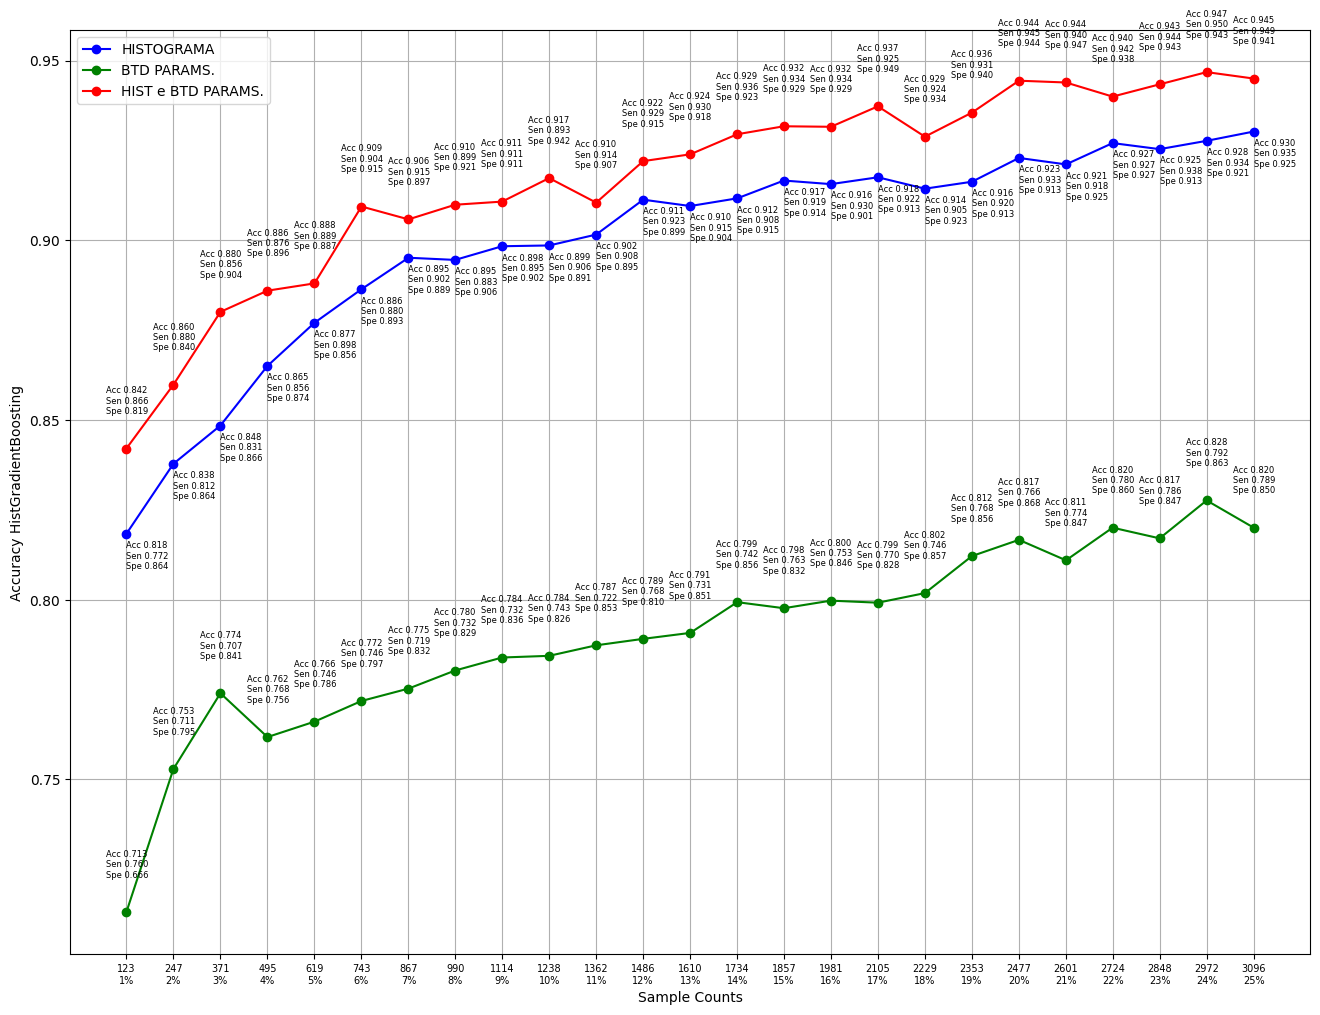

In [64]:
x_experiments = (
    [x_hist, "HISTOGRAMA", "b"],
    [x_btd, "BTD PARAMS.", "g"],
    [X, "HIST e BTD PARAMS.", "r"],
)

sample_counts = []
accuracies = []
labels = []

models = dict()

models["HistGradientBoosting"] = clf = HistGradientBoostingClassifier(
    **{
        "l2_regularization": 0.1,
        "learning_rate": 0.2,
        "max_depth": 7,
        "max_iter": 200,
        "min_samples_leaf": 4,
    }
)

for label, model in models.items():
    plt.figure(figsize=(16, 12))
    plt.xlabel("Sample Counts")
    plt.grid(True)
    plt.legend()

    for x_input, x_label, x_color in x_experiments:
        dataset_sample_counts = []
        dataset_accuracies = []
        dataset_sensitivities = []
        dataset_specificities = []
        dataset_labels = []

        data_percentages = np.arange(25, 0, -1) / 100

        for train_data_percentage in data_percentages:
            train_data_percentage = round(train_data_percentage, 4)

            num_samples = int(len(x_input) * train_data_percentage)

            x_train, x_test, y_train, y_test = train_test_split(
                x_input, y, test_size=1 - train_data_percentage
            )

            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)

            accuracy = accuracy_score(y_test, y_pred)

            confusion = confusion_matrix(y_test, y_pred)
            (
                true_negatives,
                false_positives,
                false_negatives,
                true_positives,
            ) = confusion.ravel()

            sensitivity = true_positives / (true_positives + false_negatives)
            specificity = true_negatives / (true_negatives + false_positives)

            dataset_sensitivities.append(sensitivity)
            dataset_specificities.append(specificity)

            dataset_sample_counts.append(num_samples)
            dataset_accuracies.append(accuracy)
            dataset_labels.append(f"{num_samples}\n{train_data_percentage * 100:.0f}%")

        dataset_results_df = pd.DataFrame(
            {
                "Sample Counts": dataset_sample_counts,
                "Accuracy": dataset_accuracies,
                "Sensitivity": dataset_sensitivities,
                "Specificity": dataset_specificities,
            }
        )

        plt.xticks(dataset_sample_counts, dataset_labels, fontsize=7)

        plt.plot(
            dataset_results_df["Sample Counts"],
            dataset_results_df["Accuracy"],
            marker="o",
            label=x_label,
            color=x_color,
        )

        y_axis = -25 if x_color == "b" else 25
        x_axis = 0 if x_color == "b" else -15

        for i, (acc, sens, spec) in enumerate(
            zip(
                dataset_results_df["Accuracy"],
                dataset_results_df["Sensitivity"],
                dataset_results_df["Specificity"],
            )
        ):
            plt.annotate(
                f"Acc {acc:.3f}\nSen {sens:.3f}\nSpe {spec:.3f}",
                (dataset_sample_counts[i], acc),
                fontsize=6,
                textcoords="offset points",
                xytext=(int(x_axis), int(y_axis)),
            )

        plt.legend()

    plt.ylabel(f"Accuracy {label}")
    plt.show()

## Confidence Interval

In [66]:
clf = HistGradientBoostingClassifier(
    **{
        "l2_regularization": 0.1,
        "learning_rate": 0.2,
        "max_depth": 7,
        "max_iter": 200,
        "min_samples_leaf": 4,
    }
)

n_bootstrap_samples = 5

bootstrap_acc = []
bootstrap_sen = []
bootstrap_spe = []

X = X

for n in range(n_bootstrap_samples):
    # Resample the dataset with replacement
    indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
    x_bootstrap = X[indices]
    y_bootstrap = y[indices]

    acc, sen, spe = get_results(clf, x_bootstrap, y_bootstrap)

    bootstrap_acc.append(acc)
    bootstrap_sen.append(sen)
    bootstrap_spe.append(spe)

    clear_output(wait=True)

4 17
Fold 1: Accuracy: 0.983, Sensitivity: 0.994, Specificity: 0.973
14 15
Fold 2: Accuracy: 0.977, Sensitivity: 0.977, Specificity: 0.976
8 7
Fold 3: Accuracy: 0.988, Sensitivity: 0.987, Specificity: 0.989
9 11
Fold 4: Accuracy: 0.984, Sensitivity: 0.985, Specificity: 0.982
9 5
Fold 5: Accuracy: 0.989, Sensitivity: 0.985, Specificity: 0.992
12 8
Fold 6: Accuracy: 0.984, Sensitivity: 0.981, Specificity: 0.987
3 11
Fold 7: Accuracy: 0.989, Sensitivity: 0.995, Specificity: 0.982
11 7
Fold 8: Accuracy: 0.985, Sensitivity: 0.982, Specificity: 0.989
17 14
Fold 9: Accuracy: 0.975, Sensitivity: 0.972, Specificity: 0.977
7 6
Fold 10: Accuracy: 0.989, Sensitivity: 0.989, Specificity: 0.990
Mean Accuracy: 0.984 ± 0.005
Mean Sensitivity: 0.985 ± 0.007
Mean Specificity: 0.984 ± 0.006


In [67]:
# Calculate the 95% confidence interval
lower_bound = np.percentile(bootstrap_acc, 2.5)
upper_bound = np.percentile(bootstrap_acc, 97.5)
print(f"95% Confidence Interval for Accuracy: ({lower_bound:.4f}, {upper_bound:.4f})")

95% Confidence Interval for Accuracy: (0.9837, 0.9864)


In [68]:
# Calculate the 95% confidence interval
lower_bound = np.percentile(bootstrap_acc, 2.5)
upper_bound = np.percentile(bootstrap_acc, 97.5)
print(f"95% Confidence Interval for Accuracy: ({lower_bound:.4f}, {upper_bound:.4f})")

95% Confidence Interval for Accuracy: (0.9837, 0.9864)
